<a href="https://colab.research.google.com/github/sirfindcent/dog-vision/blob/main/end_to_end_dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐶 End-to-end Multi-class Dog Breed Classification

This notebook builds an end-to-end multi class image classifier using Tensorflow 2.0 and TensorFlow hub. In this project we're going to be using machine learning to help us identify different breeds of dogs.

<img src="https://github.com/sirfindcent/dog-vision/blob/main/images/dog-vision-goal.png?raw=true">

We're going to go through the following TensorFlow/Deep Learning workflow:
1. Get data ready (download from Kaggle, store, import).
2. Prepare the data (preprocessing, the 3 sets, X & y).
3. Choose and fit/train a model ([TensorFlow Hub](https://www.tensorflow.org/hub), `tf.keras.applications`, [TensorBoard](https://www.tensorflow.org/tensorboard), [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)).
4. Evaluating a model (making predictions, comparing them with the ground truth labels).
5. Improve the model through experimentation (start with 1000 images, make sure it works, increase the number of images).
6. Save, sharing and reloading your model (once you're happy with the results).

## 0. Using this notebook
To use this notebook, you have to change **the current directory** on the code into your **own directory**.

For example `/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog-Vision` into `/content/drive/MyDrive/your-path`.

Then, you will be fine running all the code in this notebook.

## 1. Problem
> Identifying dog breed given an image of the dog.

Humans can distinguish 10-20 dog breeds, but it is difficult to memorize over 100 breeds. This is because there are many different features that can be used to identify a dog breed, such as ear shape, facial shape, tail length, and fur color.
Even if we memorize all of these features, it is still difficult to correctly identify a dog breed if we have not seen it before. A program that can identify dog breeds from photos would be helpful because it would allow us to quickly and easily learn about the different breeds.

## 2. Data
The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data


## 3. Evaluation
The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation


## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set (these images have labels).
* There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them).

## Getting the data
Before run this code below:
1. Download the `dog-breed-identification.zip` here: https://www.kaggle.com/c/dog-breed-identification/data
2. Upload `dog-breed-identification.zip` to your google drive
3. Mount Google Drive.
3. Modify the path to your path.

In [ ]:
# Unzip the uploaded data into Google Drive
!unzip './dog-breed-identification.zip' -d '/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision'


## Getting our workspace ready

* Import TensorFlow 2.X ✅
* Import TensorFlow Hub✅
* Make sure we're using GPU✅


In [ ]:
#Import tensorflow into colab
import tensorflow as tf
import tensorflow_hub as hub

print('TF version:', tf.__version__)
print('TF Hub version:', hub.__version__)

#Check for the GPU availability
print( "GPU", "available (YESSSS!!!!!" if tf.config.list_physical_devices("GPU") else "Not available : (")

TF version: 2.12.0
TF Hub version: 0.14.0
GPU available (YESSSS!!!!!


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Get the data ready (turning into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representations).

Let's start by accessing our data and checking out the labels.

In [ ]:
#Checkout the labels of data
import pandas as pd

labels_csv = pd.read_csv('/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/labels.csv')

print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [ ]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

<Axes: >

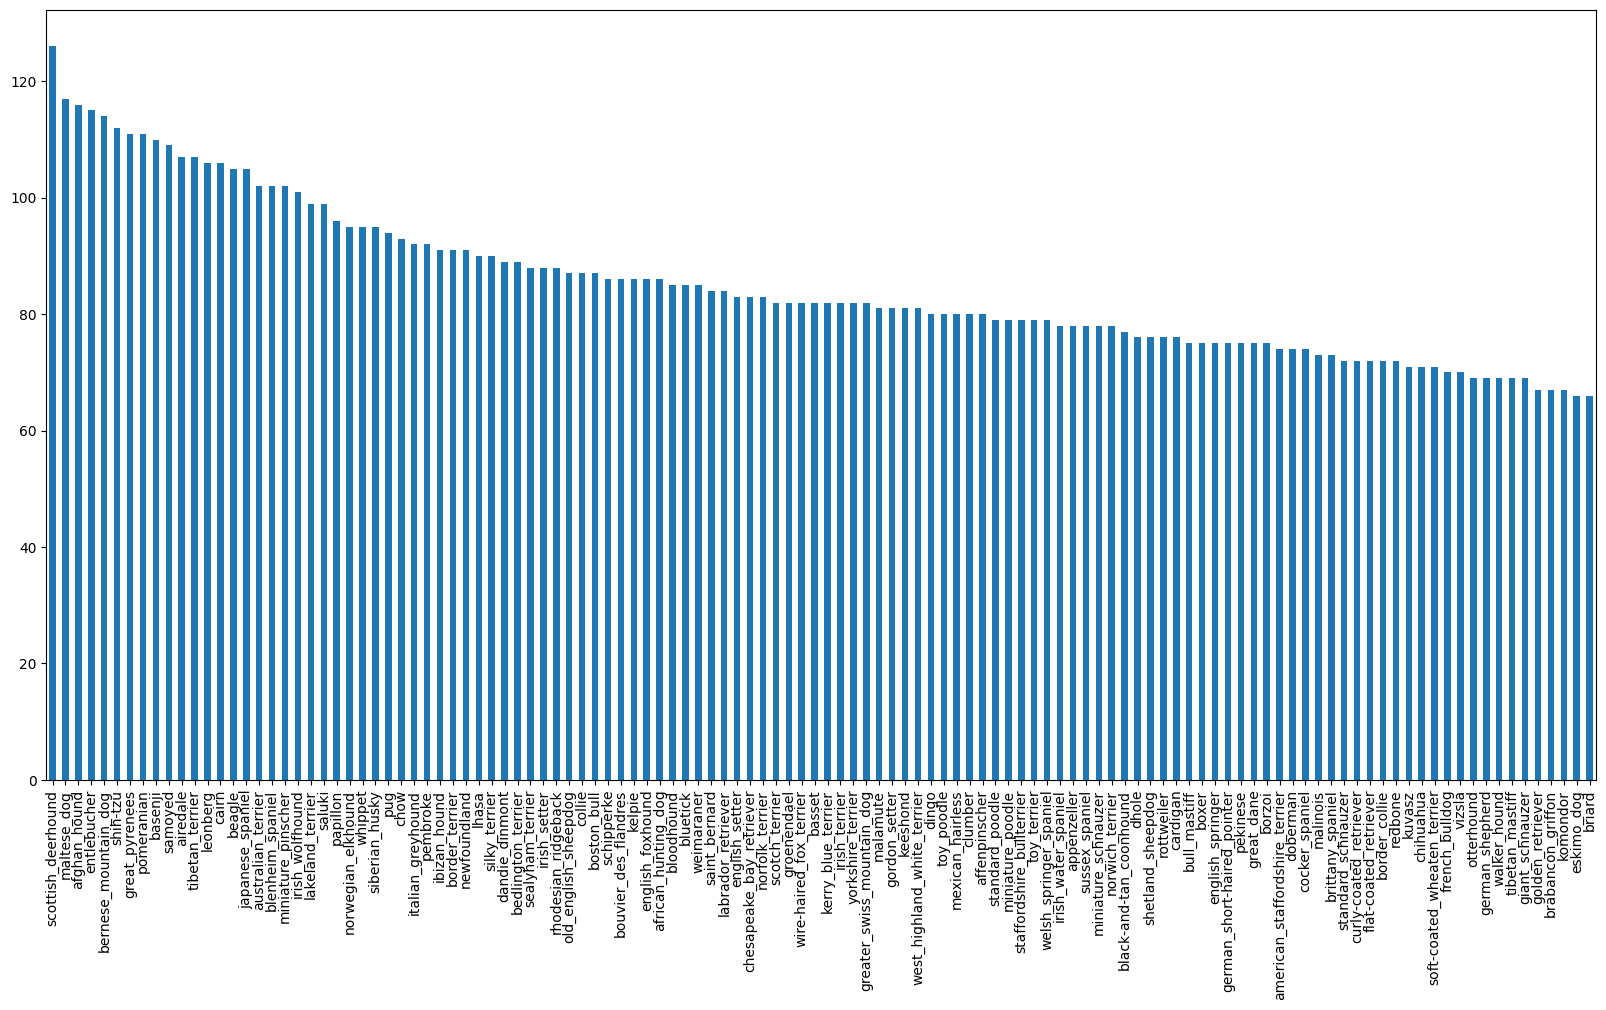

In [ ]:
# How many images are there of each breed
labels_csv['breed'].value_counts().plot.bar(figsize=(20, 10))

In [ ]:
# What's the median number of images per class?
labels_csv["breed"].value_counts().median()

82.0

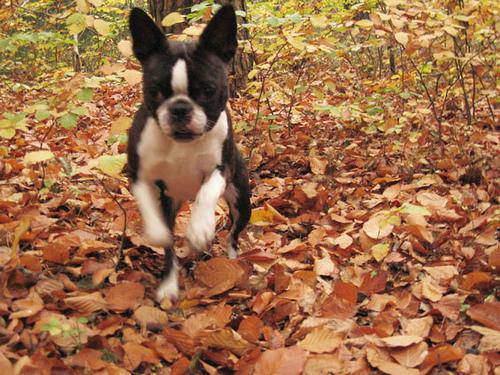

In [ ]:
# Let's view one image from the train folder
from IPython.display import Image
Image("/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

### Getting images and their labels
Let's get a list of all our image file pathnames

In [ ]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [ ]:
import os
os.listdir()

['.config', 'drive', 'sample_data']

In [ ]:
# Create pathnames from image ID's
filepath = "/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/train/"
filenames = [filepath + fname + ".jpg" for fname in labels_csv['id'] ]

# Check the first 10 of our data
filenames[:10]

['/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/train/003df8b8a8b05

In [ ]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir('/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/train')) == len(filenames) :
  print("Filenames match actual amount of file!!! proceed.")
else:
  print("Filenames do not match actual amount of files, check the target directory.")

Filenames match actual amount of file!!! proceed.


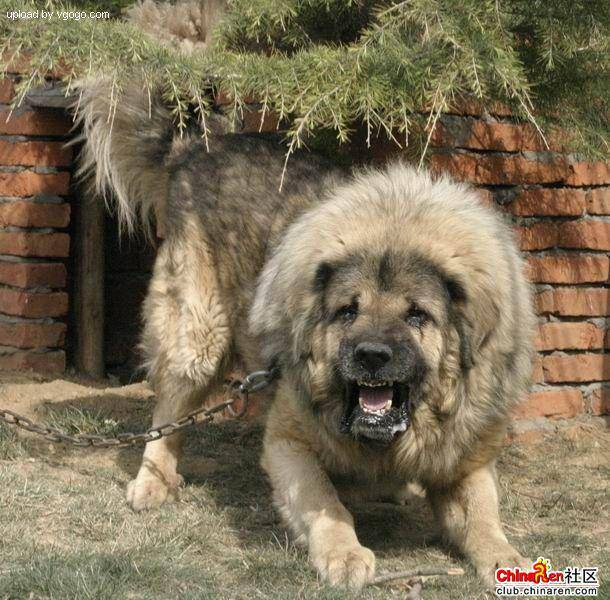

In [ ]:
# One more check
Image(filenames[9000])

In [ ]:
labels_csv['breed'][9000]

'tibetan_mastiff'

Since we've now got our training images file path in a list, let's prepare our labels

### Turning labels into numpy array

In [ ]:
import numpy as np
labels = labels_csv['breed'].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
len(labels)

10222

In [ ]:
# See if number the labels matches to numbers of filename
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories!")

Number of labels matches number of filenames!


In [ ]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

#### Turning labels into booleans

In [ ]:
# Turn single label into array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
# Turn every label into boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
len(boolean_labels)

10222

In [ ]:
boolean_labels[0].argmax

<function ndarray.argmax>

In [ ]:
# Example turning array into integer
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [ ]:
print(labels[2])
print(boolean_labels[2].astype(int))
print(boolean_labels[2].argmax())

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
85


### Creating our own validation set
Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [ ]:
# Setup features and label
X = filenames
y = boolean_labels

We're going to start of experimenting with ~1000 images and increase as needed


In [ ]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider",min:1000, max:10000, step:1000}

In [ ]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGE
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [ ]:
# Let's have a geez at the training data
X_train[:2], y_train[:1]

(['/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  '/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False

## Preprocessing Images (turning images into Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image (convert color channel values from from 0-255 to 0-1).
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image`

Before we do, let's see what importing an image looks like.

In [ ]:
# Convert image to Numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [ ]:
image.max(), image.min()

(255, 0)

In [ ]:
image

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]],

       [[ 56, 104,  66],
        [ 58, 106,  68],
        [ 64, 112,  74],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 74, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  11],
        [  8,  14,  14],
        ...,
        [120, 113,  67],
        [126, 118,  71],
        [122, 114,  67]],

       [[  0,   3,   7],
        [  2,   7,  10],
        [  3,   9,   7],
        ...,
        [105,  98,  54],
        [112, 104,  58],
        [111, 103,  57]],

       [[ 16,  18,  30],
        [ 16,  19,  24],
        [ 15,  20,  14],
        ...,
        [101,  92,  51],
        [ 97,  88,  47],
        [120, 111,  70]]

In [ ]:
# turn an image into a tensor
tf.constant(image)
image

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]],

       [[ 56, 104,  66],
        [ 58, 106,  68],
        [ 64, 112,  74],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 74, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  11],
        [  8,  14,  14],
        ...,
        [120, 113,  67],
        [126, 118,  71],
        [122, 114,  67]],

       [[  0,   3,   7],
        [  2,   7,  10],
        [  3,   9,   7],
        ...,
        [105,  98,  54],
        [112, 104,  58],
        [111, 103,  57]],

       [[ 16,  18,  30],
        [ 16,  19,  24],
        [ 15,  20,  14],
        ...,
        [101,  92,  51],
        [ 97,  88,  47],
        [120, 111,  70]]

In [ ]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a TensorFlow
  """

  #Read in an images file
  image = tf.io.read_file(image_path)

  #Turn the image into Numerical Tensor with 3 color channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)

  #Convert the color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)

  #Resize the image to our desired value
  image= tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

## Turning our data into batches

Why turn our data into batches??

Let's say you're trying to process 10.000+ images in one go ... they all might not fit into memory

So that's why we do 32(this is batch size) images at time(you can adjust batch size manually if you need)

In order to use our TensorFlow effectively, we need our data in form of TensorFlow Tuples which look like this:
`(image, label)`

In [ ]:
# Create a simply function to return the tensor tuple
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label
  procceses the images and returns a tuple of (image, label)
  """

  image = process_image(image_path)
  return image, label

In [ ]:
# Demo of the above
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuple of Tensors in the form of `(image, label)`, let's make a function to turn all of our (`X`, `y`) into batches!

And based on my previous experiment when I was training our model, our model was **overfitting**.

So to prevent overfitting I am gonna:
* Add data augmentation to our `create-batch()` function
* Try drop out

#### Data Augmentation
Data augmentation simply allows the model to not see the exact same images twices.

This can do by configuring the random of transformations to be performed on the images .
**Note:** Augmentation only be apply to training data


In [ ]:
from tensorflow.keras import layers
# Lets stick with current data augmentation and trying to imporve it
# Set up data augmentation
data_augmentation = tf.keras.Sequential([
                                         layers.RandomFlip("horizontal_and_vertical"),
                                         layers.RandomRotation(0.2),
                                         layers.RandomZoom(height_factor=(-0.1, -0.1), #20% +20%
                                                           width_factor=None,
                                                           fill_mode='reflect',
                                                           interpolation='bilinear',
                                                           seed=42),
                                         layers.RandomContrast(factor= 0.4),
                                         layers.RandomTranslation(
                                                               height_factor=(0.2),
                                                               width_factor=(0.2),
                                                               fill_mode='reflect',
                                                               interpolation='bilinear')])

#Since our data augmentation didn't really improve our model accuracy, we did not continue using it

In [ ]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Set Autotune for data augmentation
AUTOTUNE = tf.data.AUTOTUNE

# Create a function to turn data into batches
def create_batch(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data= False, augment=False):
  """
  Create a batches out of images(X) and label(y) pair
  Shuffles the data if it's training data but doesn't shuffled if it validation data
  And use accepts test data as input (no labels)
  """

  # If the data is test datasets we probablY don't have labels
  if test_data:
    print("Creating data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x)))
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is valid dataset we don't need to shuffled it
  elif valid_data:
    print("Creating validation data batches...")

    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), #Filepaths
                                              tf.constant(y))) #label

    data_batch = data.map(get_image_label).batch(BATCH_SIZE)


    return data_batch

  else:
    print("Creating training data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                               tf.constant(y)))

    # Reshuffling the path imamge and label befor mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size= len(x) )

    # Create (image,label) tuple (this also turn the image path into preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch= data.batch(BATCH_SIZE)


  # Set the data augmentation for training data
    if augment:
      data_batch = data_batch.map(lambda x, y:(data_augmentation(x, training=True), y),
                                  num_parallel_calls = AUTOTUNE)
      return data_batch.prefetch(buffer_size= AUTOTUNE)
    else:
      return data_batch


In [ ]:
# Create training and validation data batches
train_data = create_batch(X_train, y_train, augment=False)
valid_data = create_batch(x=X_val, y =y_val, valid_data=True)



Creating training data batches...
Creating validation data batches...


In [ ]:
data = tf.data.Dataset.from_tensor_slices((tf.constant(X_train),
                                           tf.constant(y_train)))

data = data.map(process_image)
data_batch = data.batch(BATCH_SIZE)
data_batch.element_spec

TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)

In [ ]:
# Check our different attributes of our data batches
train_data.element_spec, valid_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing our batches

Our data is now on batches, however, these can be little hard to understand/comprehend, let's visualize them

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Create a function for viewing image in a data batch
def show_25_image(image, label):
  """
 Displays a plot of 25 image and their label from data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10,10))

  # Loop through 25 images
  for i in range(25):
    # Set up subplots(5 rows, 5 col)
    ax = plt.subplot(5, 5, i+1)

    # Display an image
    plt.imshow(image[i])

    # Add the image label as the title
    # Simply by looping unique breed where the boolean labels is true
    plt.title(unique_breeds[label[i].argmax()])

    # Turn the grid lines off
    plt.axis("off")

In [ ]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

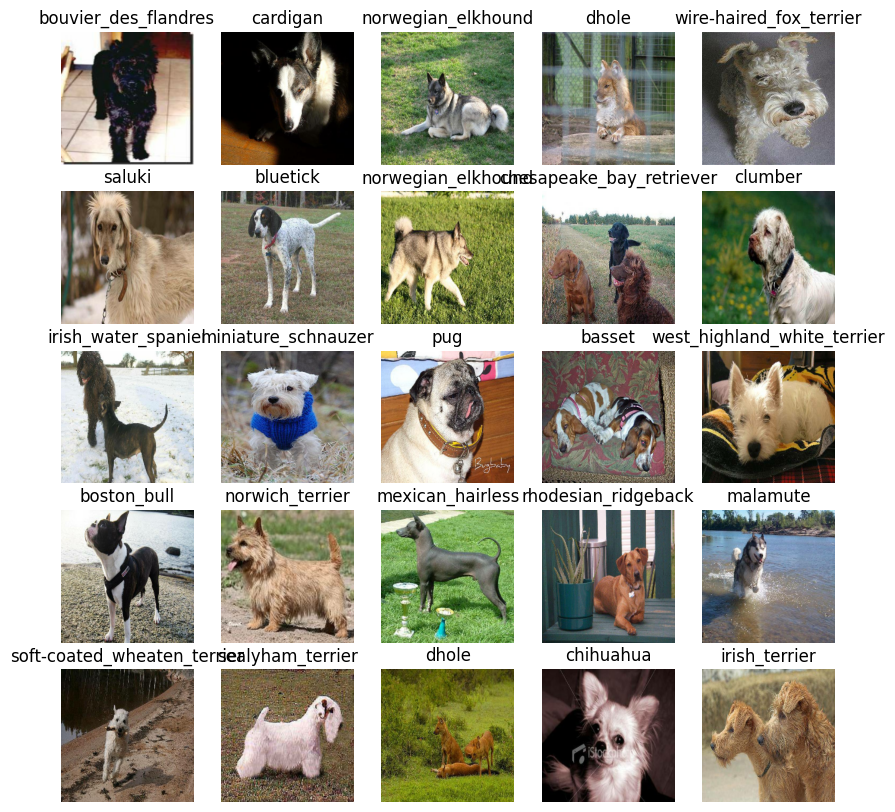

In [ ]:
# Now let's visualize the data in the training batch
train_image, train_labels = next(train_data.as_numpy_iterator())
show_25_image(train_image, train_labels)

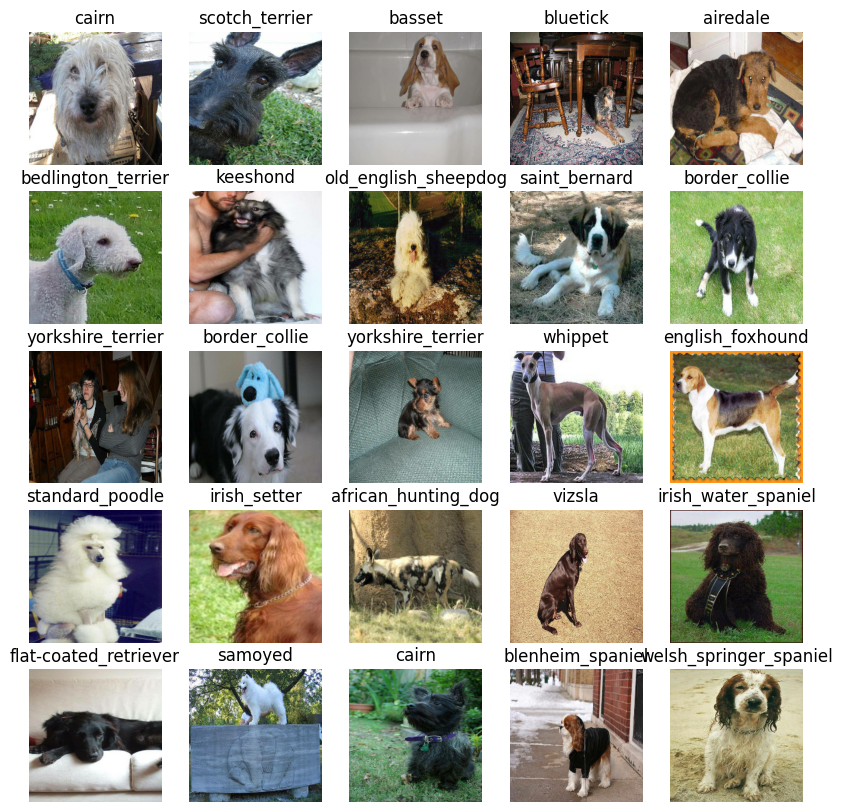

In [ ]:
#Now let's visualize our validation data
#Turn validation batch into numpy iterator
valid_image, valid_labels = next(valid_data.as_numpy_iterator())
show_25_image(valid_image, valid_labels)

## Building a model
Before we build a model, there are a few things we need to define:
* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from TensorFlow Hub - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [ ]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]  #batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"


Now we've got our inputs, outputs and model ready to go. Let's put them together into a Keras deep learning model!

Knowing this, let's create a function which:
* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in sequential fashion (do this first, then this, then that).
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tells the model the input shape it'll be getting).
* Returns the model.

All of these steps can be found here: https://www.tensorflow.org/guide/keras/overview

#### Mobile net v2

In [ ]:
# Mobile net v2
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL,):
  print("Building model with:", MODEL_URL)

  # Set up the model
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), #Layer 1 (input layer)

    tf.keras.layers.Dropout(0.5), #Layer 2 to prevent overfitting

    tf.keras.layers.Dense(units= OUTPUT_SHAPE,
                  activation="softmax"), #Layer 3 outputlayer


])

  # Compile the model
  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ["accuracy"]
  )

  # Build the model
  model.build(input_shape)

  return model

### Loading saved model

In [ ]:
# Create a function to load our trained model
def load_model(model_path):
  """
  Load a saved model from specified path
  """
  print(f"Loading saved model from {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer": hub.KerasLayer})

  return model

In [ ]:
# Load a trained model
model = load_model("/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/models/2021-10-16-072145-1000-dropout-mobilenetv2-trained-Adam.h5")
model.summary()

Loading saved model from /content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/models/2021-10-16-072145-1000-dropout-mobilenetv2-trained-Adam.h5
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_9 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dropout (Dropout)           (None, 1001)              0         
                                                                 
 dense_9 (Dense)             (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks

Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.

### TensorBoard Callback

To setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension ✅
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function. ✅
3. Visualize our models training logs with the `%tensorboard` magic function (we'll do this after model training).

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

In [ ]:
# Load tensorboard notebook extension
%load_ext tensorboard

In [ ]:
import datetime

# Create a function to build a TensorFlow callback
def create_tensorboard_callback():

  # Create a log directory for storing TensorBoard logs
  logdir= os.path.join("/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/logs",
                       # Make it so the logs get tracked whenever we run an experiment
                       datetime.datetime.now().strftime("%Y-%m-%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [ ]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

# Create tensorboard callbacks
tensor_board = create_tensorboard_callback()

## Training a model (on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [ ]:
NUM_EPOCHS= 100 #@param {type:"slider", min:10, max:100, step:10}

In [ ]:
# Check to make sure we're still running on gpu
print("GPU","Yessss" if tf.config.list_physical_devices("GPU") else "Not available")

GPU Yessss


Let's create a function which train model:
* Create a model using `create_model()`
* Set up TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it on training data, validation data, number of epochs to train for(`NUM_EPOCHS`) and the callback we'd like to use
* Return the model


In [ ]:
# Build a function to train and return train model
def train_model():
  """
  Train the given model and returns the trained version
  """

  # Create model
  model = create_model()

  # Create a new TensorBoard session evertime we train the model
  tensor_board = create_tensorboard_callback()

  # Fit the data to passing it to callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data =valid_data,
            validation_freq=1,
            callbacks=[tensor_board, early_stopping])
  # Return the fitted model
  return model

In [ ]:
# Fit the model to the data
# model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Train for 25 steps, validate for 7 steps
Epoch 1/100
25/25 [==============================] - 604s 24s/step - loss: 4.5757 - accuracy: 0.0988 - val_loss: 3.4853 - val_accuracy: 0.2200
Epoch 2/100
25/25 [==============================] - 4s 179ms/step - loss: 1.6390 - accuracy: 0.6900 - val_loss: 2.1415 - val_accuracy: 0.5100
Epoch 3/100
25/25 [==============================] - 4s 175ms/step - loss: 0.5734 - accuracy: 0.9388 - val_loss: 1.6463 - val_accuracy: 0.6050
Epoch 4/100
25/25 [==============================] - 4s 176ms/step - loss: 0.2523 - accuracy: 0.9912 - val_loss: 1.4408 - val_accuracy: 0.6250
Epoch 5/100
25/25 [==============================] - 4s 174ms/step - loss: 0.1475 - accuracy: 0.9987 - val_loss: 1.3662 - val_accuracy: 0.6450
Epoch 6/100
25/25 [==============================] - 4s 174ms/step - loss: 0.1007 - accuracy: 1.0000 - val_loss: 1.3218 - val_accuracy: 0.6350
Epoch 7/

### Checking the tensorboards log

The tensorboard magic function(%tensorboard) will acces the log directory we created earlier and visualized it contens.

In [ ]:
%tensorboard --logdir drive/MyDrive/Project/Classification/Dog\ Vision/logs

## Making and evaluting predictions using a trained model

### Making predictions

In [ ]:
valid_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [ ]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(valid_data, verbose=1)
predictions

7/7 [==============================] - 22s 3s/step


array([[1.4126855e-03, 6.0844950e-06, 7.0124108e-04, ..., 2.1017539e-04,
        1.2377031e-04, 1.8174911e-03],
       [4.2962930e-03, 5.3916324e-04, 9.2378920e-03, ..., 1.1018924e-03,
        2.0808829e-03, 9.6398966e-05],
       [2.3722834e-05, 3.0182631e-04, 3.5643690e-05, ..., 1.1401814e-04,
        6.6951849e-05, 9.8481530e-04],
       ...,
       [2.9888699e-07, 1.3807779e-05, 3.6980517e-05, ..., 4.6065738e-06,
        8.6305052e-05, 1.0535527e-05],
       [5.3255674e-03, 1.8668390e-04, 6.8389461e-05, ..., 4.8469268e-05,
        2.0204582e-04, 7.3757046e-03],
       [3.8578332e-04, 2.2208331e-05, 6.4575071e-03, ..., 1.7925430e-03,
        2.1655555e-03, 2.3216293e-05]], dtype=float32)

In [ ]:
predictions.shape # (200-Dimension, 120(30 rows, 4cols) of label name)

(200, 120)

In [ ]:
predictions[0]

array([1.41268549e-03, 6.08449500e-06, 7.01241079e-04, 5.48114513e-05,
       2.49909572e-05, 6.62146704e-05, 8.83327704e-03, 3.15605721e-04,
       1.27093925e-04, 9.69944886e-05, 3.08904506e-04, 4.62372205e-04,
       1.71720530e-04, 2.17090401e-05, 2.60191184e-04, 1.06719883e-04,
       8.37905282e-06, 1.45152822e-01, 1.13555116e-05, 6.03329208e-05,
       1.11606219e-04, 2.28144854e-04, 7.85929933e-06, 6.50520145e-04,
       1.15466837e-05, 8.55246253e-05, 4.91929680e-01, 3.42040294e-05,
       4.98934707e-04, 7.11801840e-05, 3.35962468e-05, 8.09686957e-04,
       7.90764578e-04, 3.84154737e-06, 1.38277574e-05, 3.59590687e-02,
       5.08682660e-06, 8.24153904e-05, 2.05558827e-05, 4.15131362e-05,
       1.60876964e-03, 5.56249006e-06, 7.59115865e-05, 1.17232674e-04,
       1.59727333e-05, 3.03520847e-05, 1.18794060e-05, 6.94664428e-04,
       9.52358969e-05, 4.91903302e-05, 3.34500772e-04, 2.10181988e-05,
       4.56928305e-04, 1.48277279e-04, 1.02217156e-04, 1.55423841e-05,
      

In [ ]:
# The highest value is the label that the model strongly believes as the correct label
unique_breeds[np.argmax(predictions[0])]

'cairn'

In [ ]:
# First prediction
index= 42

print(predictions[0])
print(f"Max value (probability of prediction: {np.max(predictions[0]) }")
print(f"Sum:{np.sum(predictions[0])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[1.41268549e-03 6.08449500e-06 7.01241079e-04 5.48114513e-05
 2.49909572e-05 6.62146704e-05 8.83327704e-03 3.15605721e-04
 1.27093925e-04 9.69944886e-05 3.08904506e-04 4.62372205e-04
 1.71720530e-04 2.17090401e-05 2.60191184e-04 1.06719883e-04
 8.37905282e-06 1.45152822e-01 1.13555116e-05 6.03329208e-05
 1.11606219e-04 2.28144854e-04 7.85929933e-06 6.50520145e-04
 1.15466837e-05 8.55246253e-05 4.91929680e-01 3.42040294e-05
 4.98934707e-04 7.11801840e-05 3.35962468e-05 8.09686957e-04
 7.90764578e-04 3.84154737e-06 1.38277574e-05 3.59590687e-02
 5.08682660e-06 8.24153904e-05 2.05558827e-05 4.15131362e-05
 1.60876964e-03 5.56249006e-06 7.59115865e-05 1.17232674e-04
 1.59727333e-05 3.03520847e-05 1.18794060e-05 6.94664428e-04
 9.52358969e-05 4.91903302e-05 3.34500772e-04 2.10181988e-05
 4.56928305e-04 1.48277279e-04 1.02217156e-04 1.55423841e-05
 9.24520427e-05 1.26842735e-03 4.24882077e-04 3.92747708e-02
 3.04945279e-04 6.61953209e-06 6.73467817e-04 2.37638542e-05
 4.80850664e-04 3.368803

Having the the above functionality is great but we want to be able to do it at scale.

And it would be even better if we could see the image the prediction is being made on!

**Note:** Prediction probabilities are also known as confidence levels.

In [ ]:
# Turn the prediction probabilities into their respective label(easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turn an array of prediction probabilities into a label.
  """

  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])
pred_label

'cairn'

Now since our validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels).

In [ ]:
valid_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [ ]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
 Take a batched dataset of (image,label) Tensors and
 returns seperate arrays of images and labels.
  """
  images= []
  labels= []

  # Loop through unbatched data
  for image,label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# Unbatchify our validation data
valid_images, valid_labels = unbatchify(valid_data)
valid_images[0], valid_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [ ]:
get_pred_label(valid_labels)

'bedlington_terrier'

### Evaluating predictions with visualization

Let's make some function to make these all a bit more visualize.

We'll create a function which:
* Takes an array of prediction probabilities, an array of truth labels and an array of images and an integer. ✅
* Convert the prediction probabilities to a predicted label. ✅
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot. ✅

In [ ]:
def plot_pred(predictions_probabilities, labels, images, n=1):
  """
  View the predictions, ground truth and image for sample n
  """

  pred_prob, true_label, images = predictions_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image and remove ticks
  plt.imshow(images)
  plt.xticks([])
  plt.yticks([])

  # Change the color of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color="green"
  else:
    color="red"

  # Change the title label to predicted label, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color
                                    )

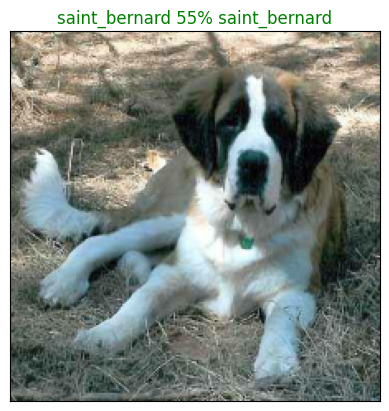

In [ ]:
plot_pred(predictions_probabilities=predictions,
          labels= valid_labels,
          images= valid_images, n=8)

Now we've got one function to visualize our models top prediction, let's make another to view our models top 10 predictions.

This function will:
* Take an input of prediction probabilities array and a ground truth array and an integer ✅
* Find the prediction using `get_pred_label()` ✅
* Find the top 10:
  * Prediction probabilities indexes ✅
  * Prediction probabilities values ✅
  * Prediction labels ✅
* Plot the top 10 prediction probability values and labels, coloring the true label green ✅

In [ ]:
def plot_pred_conf(predictions_probabilities, labels, n=1):
  """
  Plot the first top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = predictions_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]

  # Find the top 10 prediction label
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Set up plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
          top_10_pred_values,
          color="grey")

  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change the color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")



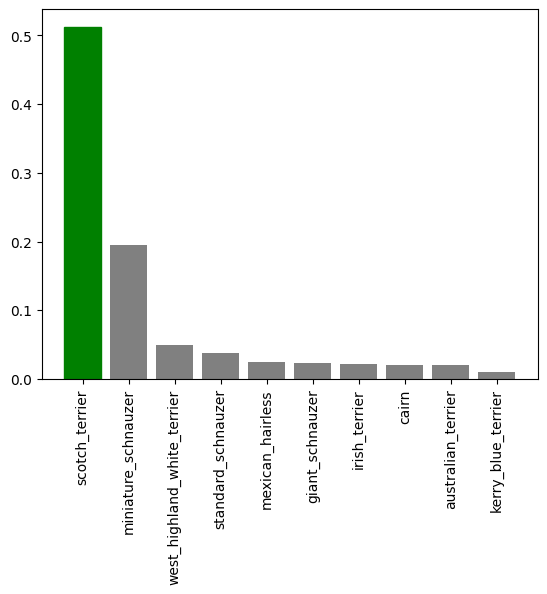

In [ ]:
plot_pred_conf(predictions_probabilities=predictions,
               labels=valid_labels,
               n=1)

Now we've got some function to visualized our predictions and evaluate our model, let's check out a few

In [ ]:
def plot_top_pred(predictions, nrows, ncols, i_multiplier=0):
  """
  Visualised the predictions and top 10 prediction confidence
  """
  num_images = nrows*ncols
  plt.figure(figsize=(10*ncols, 5*nrows)) # Figsize=(30, 10)

  for i in range(num_images):
    plt.subplot(nrows, 2*ncols, 2*i+1)
    plot_pred(predictions_probabilities=predictions,
              labels= valid_labels,
              images=valid_images,
              n=i+ i_multiplier)

    plt.subplot(nrows, 2*ncols, 2*i+2)
    plot_pred_conf(predictions_probabilities=predictions,
                   labels= valid_labels,
                   n=i+ i_multiplier)
  plt.tight_layout(h_pad=1)
  plt.show()

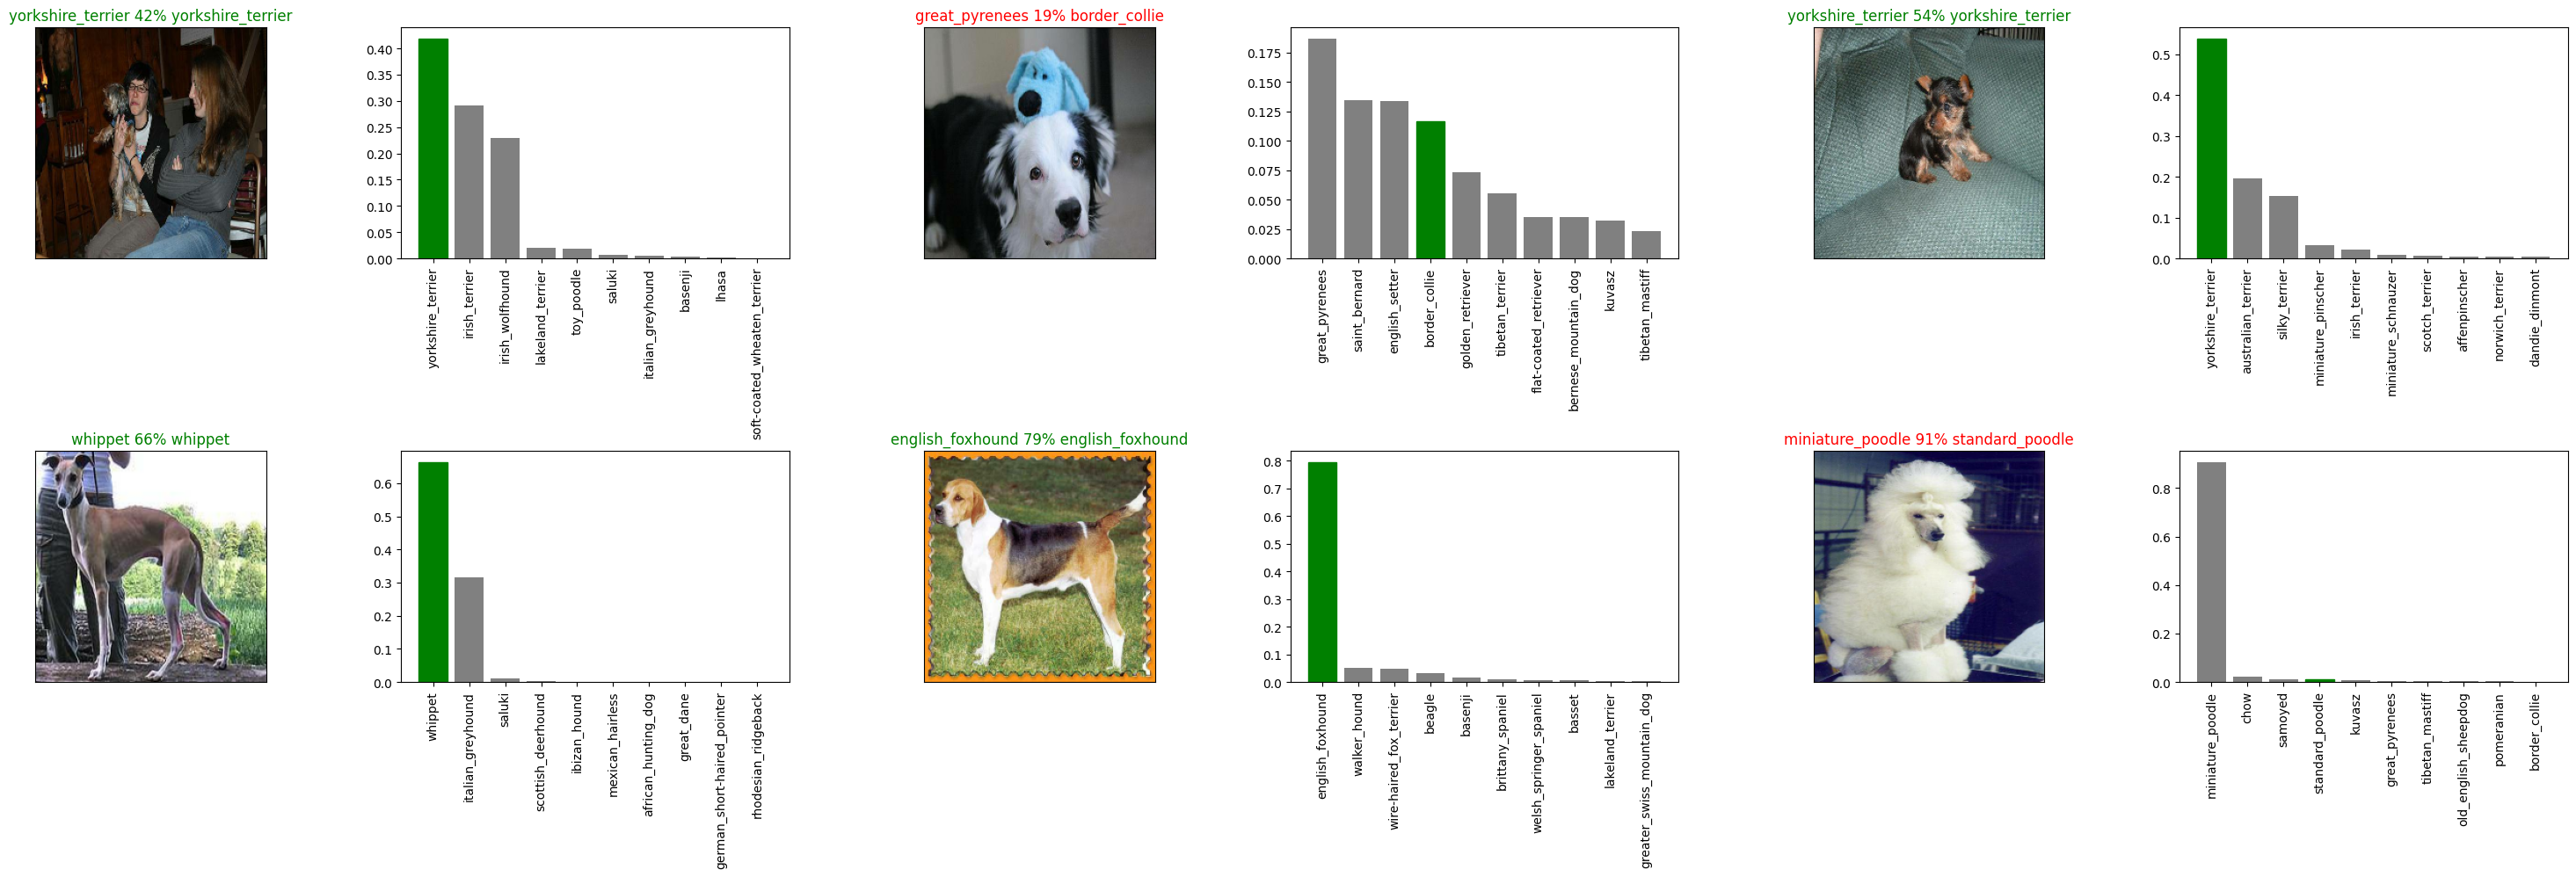

In [ ]:
plot_top_pred(predictions,nrows=2,
              ncols=3,
              i_multiplier= 10)

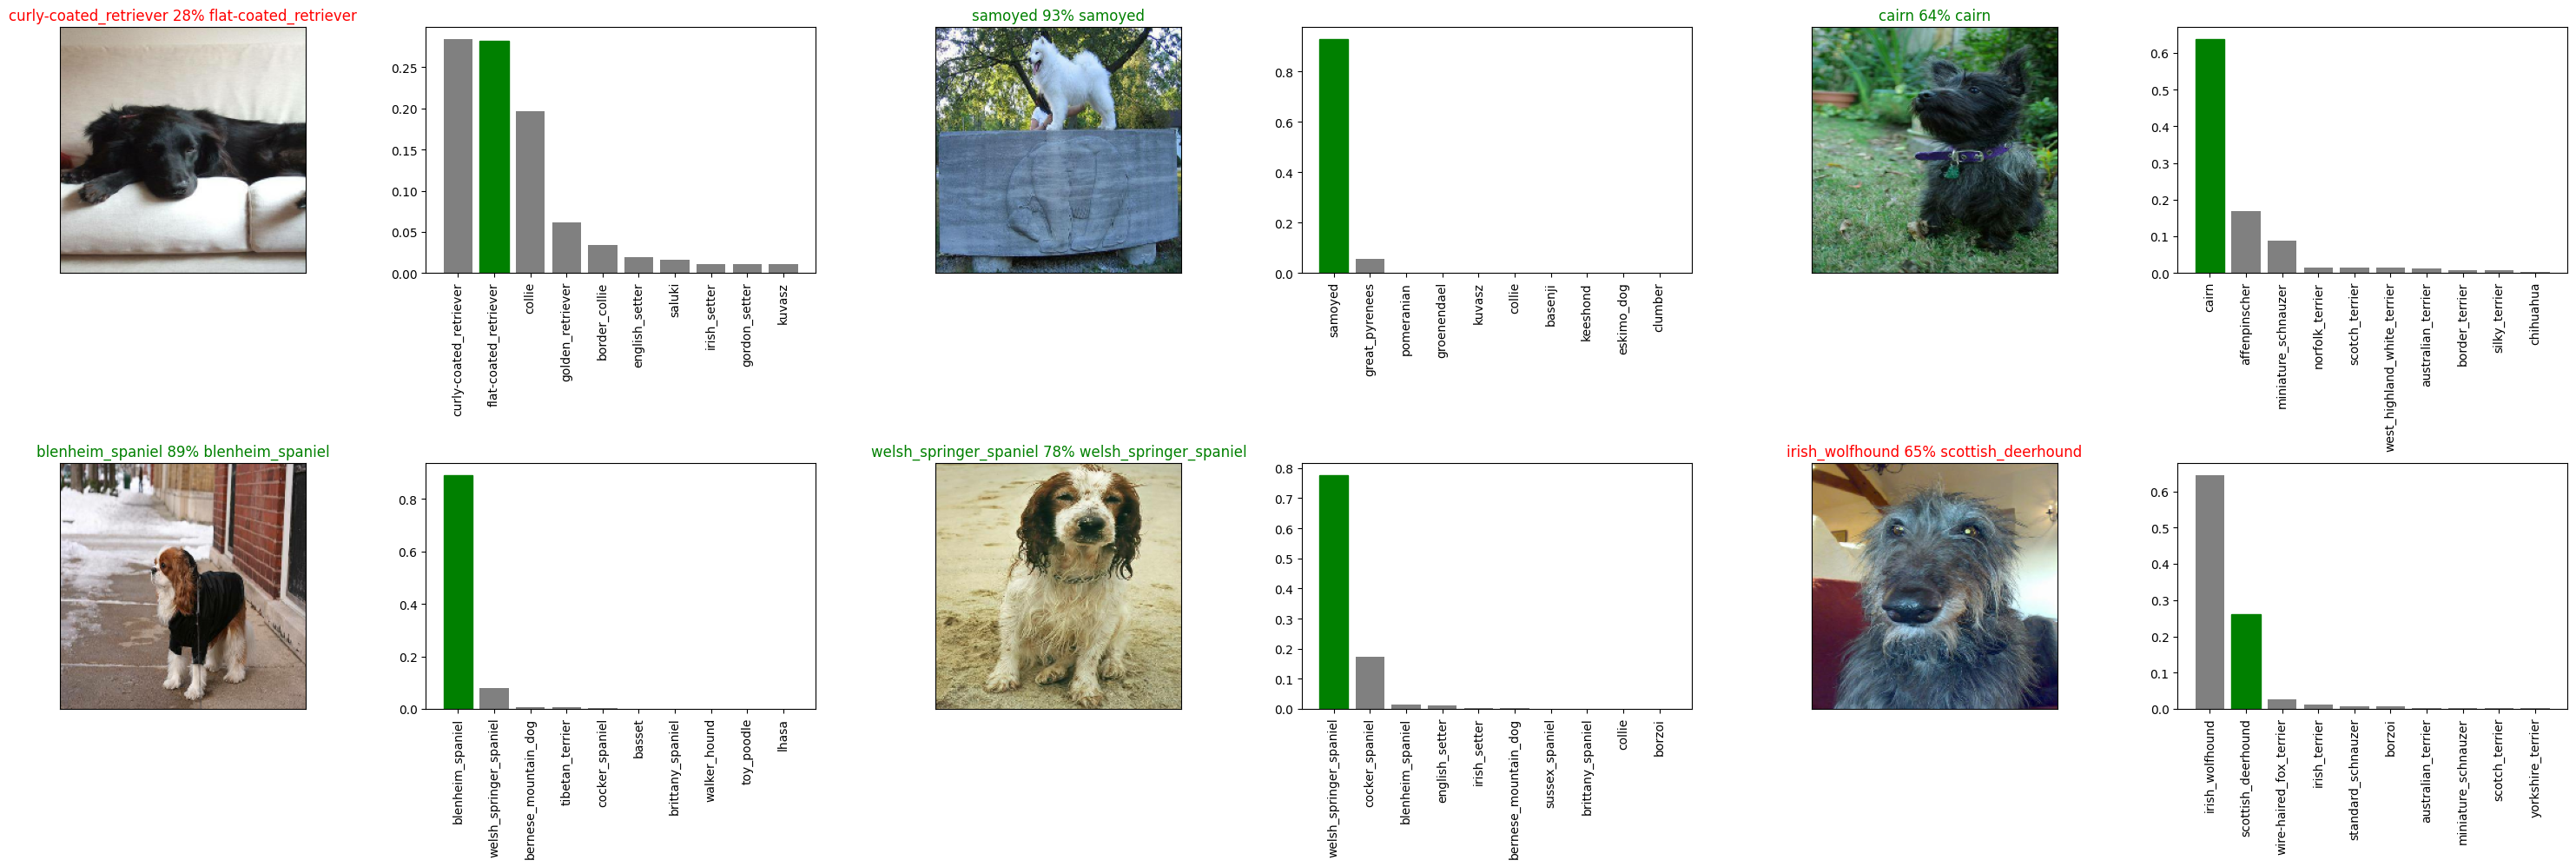

In [ ]:
# Let's check out a few predictions and their different values
i_multiplier = 20
nrows = 2
ncols = 3
num_images = nrows*ncols
plt.figure(figsize=(10*ncols, 5*nrows))

for i in range(num_images):
  plt.subplot(nrows, 2*ncols, 2*i+1)
  plot_pred(predictions_probabilities=predictions,
            labels= valid_labels,
            images= valid_images,
            n=i+i_multiplier)
  plt.subplot(nrows, 2*ncols, 2*i+2)
  plot_pred_conf(predictions_probabilities=predictions,
                 labels= valid_labels,
                 n=i+ i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()


In [ ]:
# Plot the confusion matrix
# Preparing the tools
from sklearn.metrics import confusion_matrix
import itertools

# Turn predictions label into index
predictions_ = np.argmax(predictions, axis=1)

# Confusion matrix
cm = confusion_matrix(valid_labels, unique_breeds[predictions_])

In [ ]:
# Function to plot our confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title="Confusion Matrix",
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting "normalize= True"
  """
  if normalize:
    cm= cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")

  # print(cm)

  plt.rcParams["figure.figsize"] = (60,40)
  plt.imshow(cm, interpolation="nearest",cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks= np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90)
  plt.yticks(tick_marks, classes )

  fmt= '.2f' if normalize else 'd'
  thresh = cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

Confusion matrix, without normalization


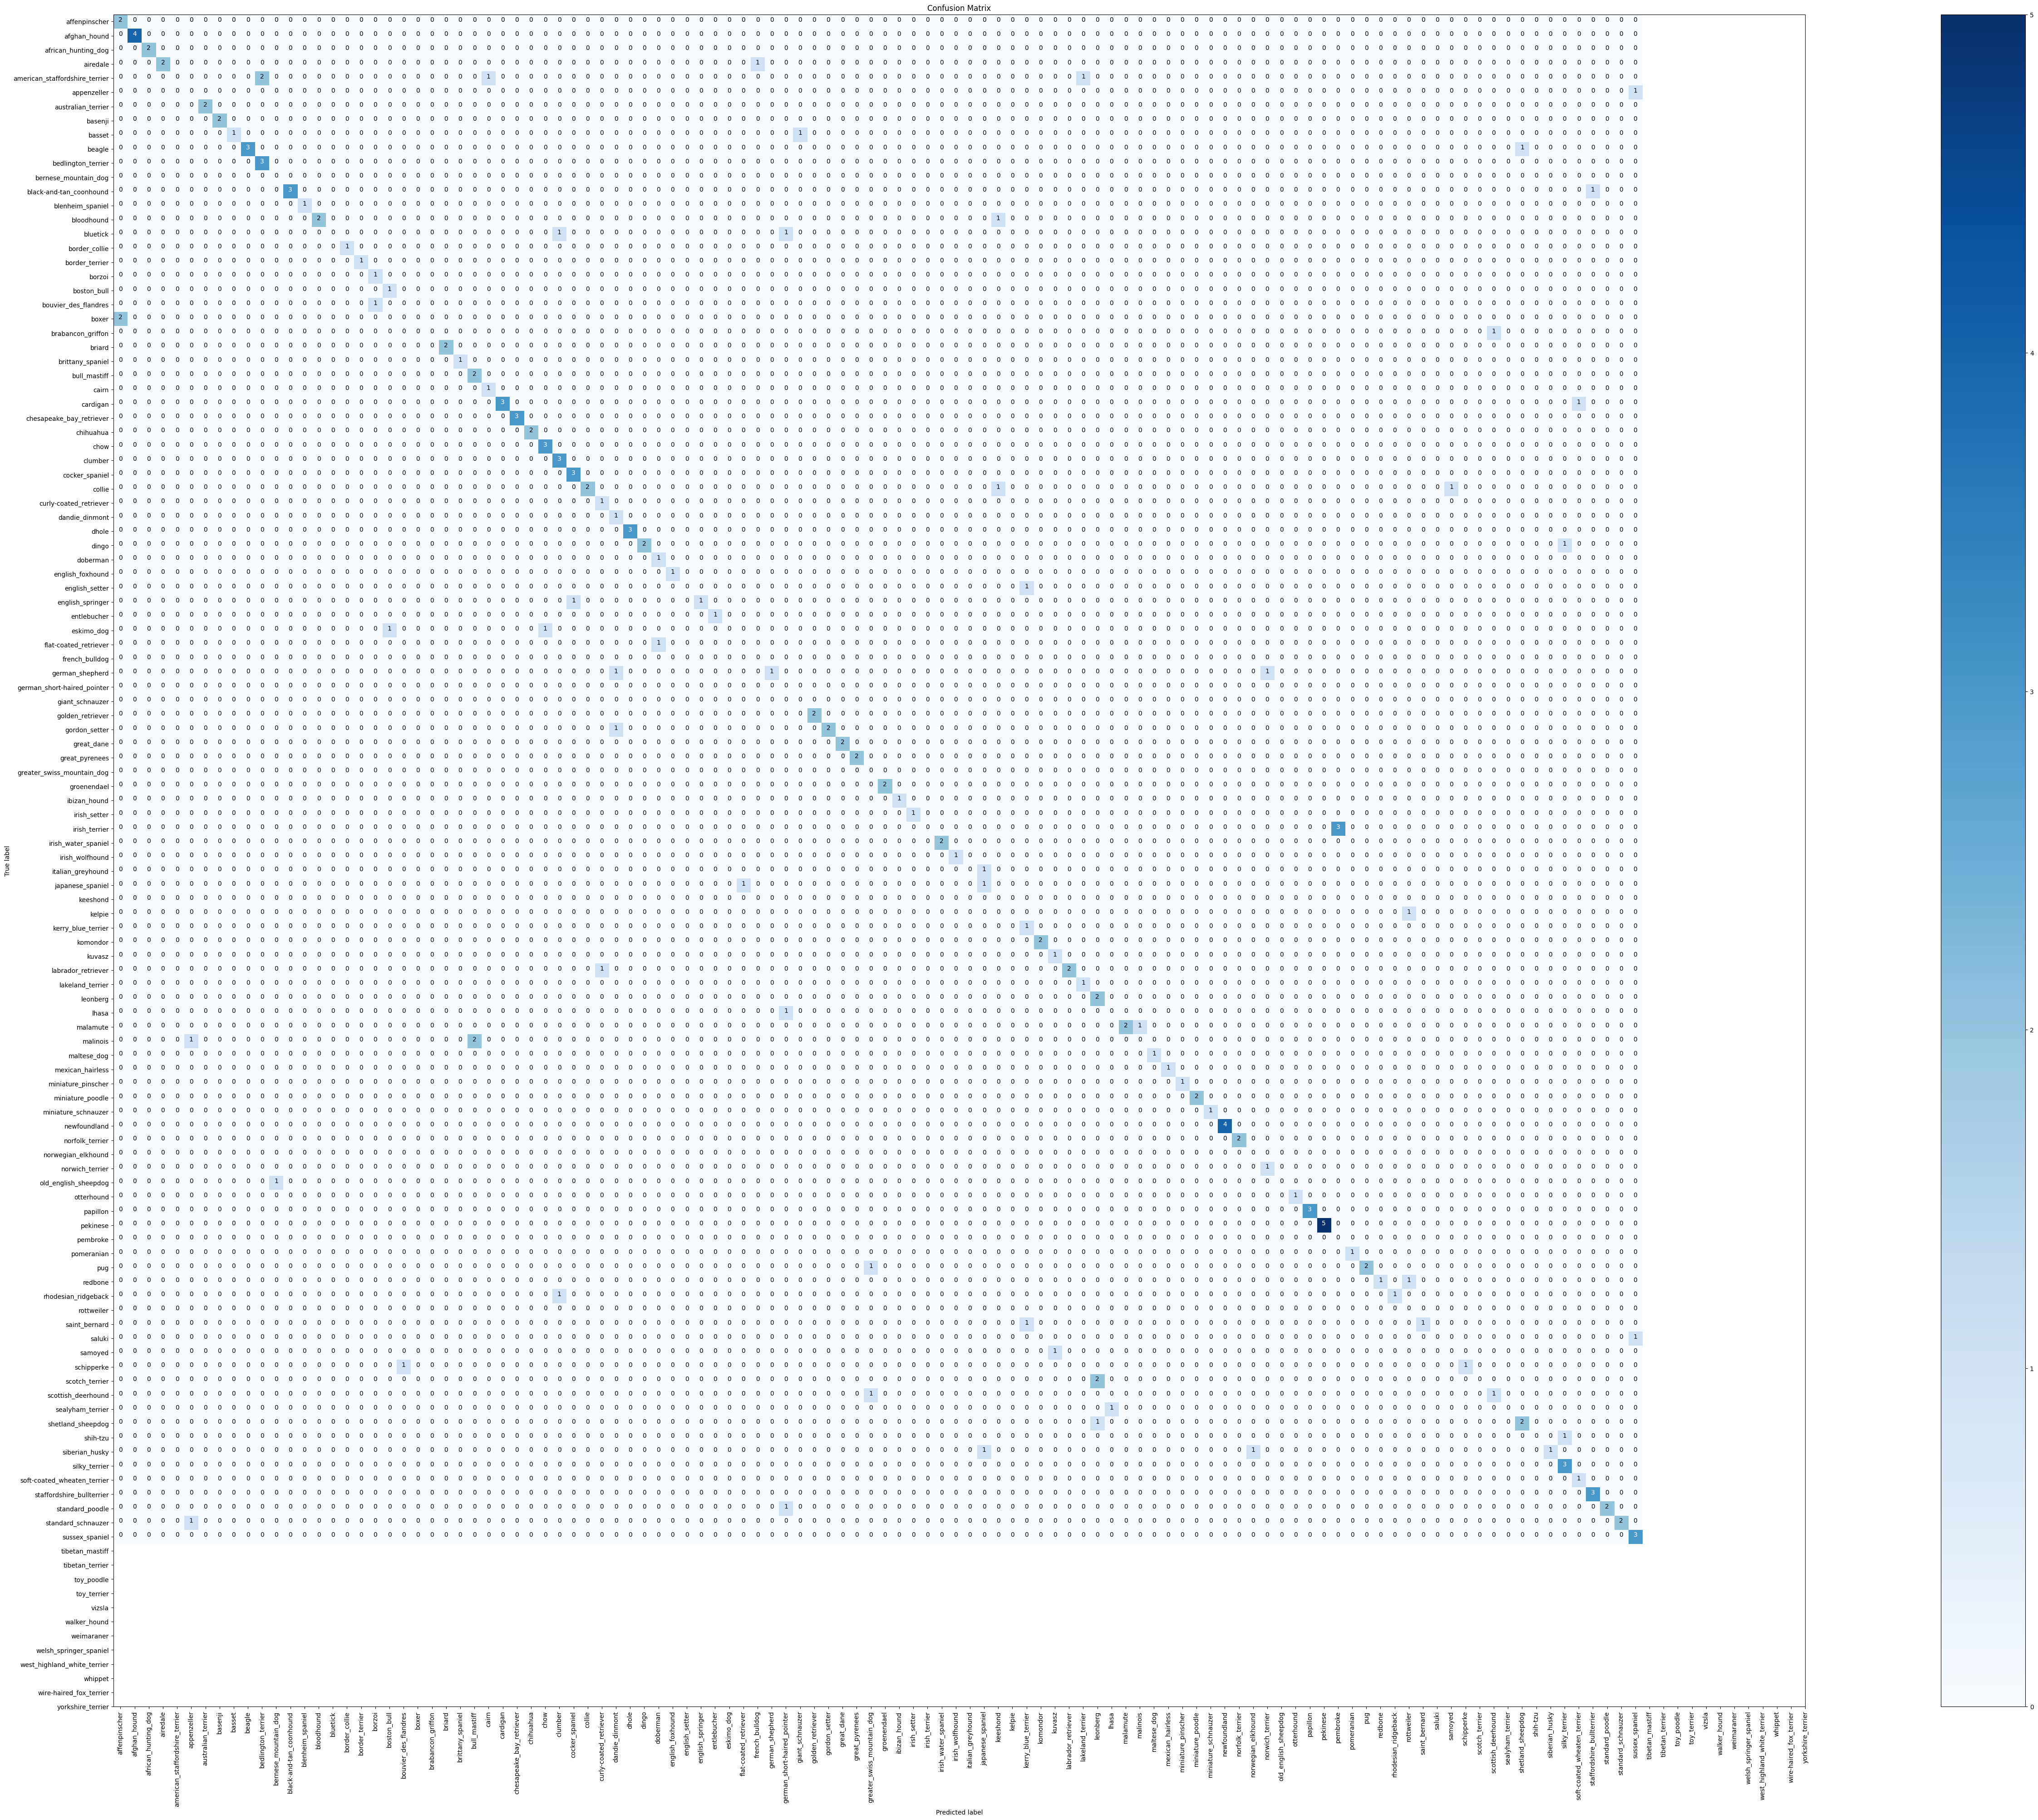

In [ ]:
# Plot huge confusion matrix
plot_confusion_matrix(cm, unique_breeds)

In [ ]:
# Saving and loading our trained model

def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix(string)
  """
  # Create a model directory with path name with current time
  modeldir = os.path.join("/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/models",
                         datetime.datetime.now().strftime("%Y-%m-%d-%H%M%S"))
  model_path = modeldir + "-" + suffix + ".h5"

  print(f"Saving the model to: {model_path}...")
  model.save(model_path)
  return model_path

Now we've got function to save and load a trained model, let's make sure they work!

In [ ]:
# Save our model on 1000 trained images
# save_model(model, suffix="1000-images-mobilenetv2-Adam-2")

In [ ]:
# Load a trained model
loaded_1000_images_model = load_model("/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/models/2021-10-04-1547$S-full-images-mobilenet-v2-Adams.h5")

Loading saved model from /content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/models/2021-10-04-1547$S-full-images-mobilenet-v2-Adams.h5


In [ ]:
# Evaluate the loaded model
model.evaluate(valid_data)

7/7 [==============================] - 1s 91ms/step - loss: 1.2046 - accuracy: 0.7100


[1.2046436071395874, 0.7099999785423279]

In [ ]:
loaded_1000_images_model.evaluate(valid_data)

7/7 [==============================] - 2s 133ms/step - loss: 0.0047 - accuracy: 1.0000


[0.004676416516304016, 1.0]

## Training big dog model 🐶(On full data)

In [ ]:
# Numbers of images on the full data
len(X), len(y)

(10222, 10222)

Following step:
1. Create a batch data
2. Create model
3. Set up callbacks (Tensorboard and early stopping)
4. Fit the full model to data
5. Save model
6. Unbatchify

In [ ]:
# Create batch with the function
full_data = create_batch(X, y)

Creating training data batches...


In [ ]:
# Create a model for full model
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


In [ ]:
# Create full model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all data, so we can't monitor the validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                            patience=3)

**Note:** Running this cell below will take a little while (maybe up to 30 minutes for the first epoch)because the GPU we're using on runtime has to load all of the images into memory.

In [ ]:
# Fit the full model to the data
# full_model.fit(x=full_data,
#                epochs=NUM_EPOCHS,
#                callbacks=[full_model_tensorboard, full_model_early_stopping])

In [ ]:
# Save the full trained model
# save_model(full_model, suffix='dropout-full-images-mobilenet-v2-Adams')

In [ ]:
# Load the full trained model
loaded_full_model= load_model("/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/models/2021-10-17-053321-dropout-full-images-mobilenet-v2-Adams.h5")

Loading saved model from /content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/models/2021-10-17-053321-dropout-full-images-mobilenet-v2-Adams.h5


## Making predictions on the test dataset

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily we created `create_data_batches()` earlier which can take a list of filenames as input and conver them into Tensor batches.

To make predictions on the test data, we'll:
* Get the test image filenames. ✅
* Convert the filenames into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True` (since the test data doesn't have labels). ✅
* Make a predictions array by passing the test batches to the `predict()` method called on our model.

In [ ]:
# Load the test image filenames
test_path = "/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames[:10]

['/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/test/e57a2bee790b512b2ba824b26f3f93fd.jpg',
 '/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/test/e18fbb12037c297b90642e99073cd6b4.jpg',
 '/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/test/e24b2d063b3ad699d5eba7a01e4ae956.jpg',
 '/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/test/e65d6492c026c925660d80543664b8a7.jpg',
 '/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/test/e241bfdd5cc6154698394905abaa0d76.jpg',
 '/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/test/e78b4a09e5f86c330e24c6aaed63f0be.jpg',
 '/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/test/e48f3d4f0514a07f4777a30f01d32ea9.jpg',
 '/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/test/df99a948e43d3399aff2e8ab2c18e184.jpg',
 '/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/test/dcd3cfe0cd6d363a3ed216

In [ ]:
len(test_filenames)

10357

In [ ]:
# Create test data batch
test_data = create_batch(test_filenames, test_data =True)

Creating data batches...


In [ ]:
test_data

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

**Note:** Calling `predict()` on our full model and passing it the test data batch will take a long time to run(about -1hr)

In [ ]:
# Make predictions on test data batch using loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

In [ ]:
# Save predictions(Numpy array )to csv file (for acces later)
# np.savetxt("/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/dropout_preds_array.csv", test_predictions, delimiter=",")

In [ ]:
# Load the predicions csv file
test_predictions = np.loadtxt("/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/dropout_preds_array.csv", delimiter=",")


In [ ]:
test_predictions[:10]

array([[1.85790841e-10, 1.91276786e-11, 9.27247237e-11, ...,
        1.46429434e-15, 4.36762345e-12, 3.49581339e-13],
       [2.24232216e-10, 8.26840194e-11, 4.69656015e-11, ...,
        1.75876952e-11, 1.15020589e-08, 2.84175994e-03],
       [5.56987789e-10, 1.31889877e-07, 1.17429355e-08, ...,
        8.02666165e-08, 8.79897470e-06, 2.85375369e-11],
       ...,
       [2.90120372e-10, 3.48277036e-15, 2.47054926e-15, ...,
        8.59749424e-11, 1.80538609e-05, 6.26775888e-12],
       [1.32505706e-09, 3.52539480e-16, 1.60679081e-09, ...,
        2.70942767e-14, 5.92788183e-08, 8.40239683e-12],
       [1.53355693e-08, 3.78908709e-08, 9.15934063e-14, ...,
        4.01000039e-10, 3.59564041e-07, 2.24925412e-08]])

In [ ]:
test_predictions.shape

(10357, 120)

## Preparing test dataset predictions for Kaggle

Looking at the Kaggle sample submission, we find that it wants our models prediction probaiblity outputs in a DataFrame with an ID and a column for each different dog breed.
https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

To get the data in this format, we'll:
* Create a pandas DataFrame with an ID column as well as a column for each dog breed. ✅
* Add data to the ID column by extracting the test image ID's from their filepaths.
* Add data (the prediction probabilites) to each of the dog breed columns.
* Export the DataFrame as a CSV to submit it to Kaggle.

In [ ]:
# ['id'] + list(unique_breed)

In [ ]:
# Create a pandas dataframe with empty columns
preds_df = pd.DataFrame(columns=['id']+ list(unique_breed))
preds_df



Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [ ]:
# Append the test images id's to predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df['id'] = test_ids


In [ ]:
preds_df.head( )

id  ... yorkshire_terrier
0  e57a2bee790b512b2ba824b26f3f93fd  ...               NaN
1  e18fbb12037c297b90642e99073cd6b4  ...               NaN
2  e24b2d063b3ad699d5eba7a01e4ae956  ...               NaN
3  e65d6492c026c925660d80543664b8a7  ...               NaN
4  e241bfdd5cc6154698394905abaa0d76  ...               NaN

[5 rows x 121 columns]

In [ ]:
os.path.splitext(test_filenames[0])

('/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/test/e57a2bee790b512b2ba824b26f3f93fd',
 '.jpg')

In [ ]:
# Add the predictions probabilities to each dog breed column
preds_df[list(unique_breed)] = test_predictions
preds_df.head()

id  ... yorkshire_terrier
0  e57a2bee790b512b2ba824b26f3f93fd  ...       3.49581e-13
1  e18fbb12037c297b90642e99073cd6b4  ...        0.00284176
2  e24b2d063b3ad699d5eba7a01e4ae956  ...       2.85375e-11
3  e65d6492c026c925660d80543664b8a7  ...       1.40774e-12
4  e241bfdd5cc6154698394905abaa0d76  ...       9.49337e-10

[5 rows x 121 columns]

In [ ]:
# Save our predictions dataframe to CSV for submission to kaggle
preds_df.to_csv("/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/full_model_predictions_submission_1_mobilenetV2.csv",
                index=False)

## Making predictions on custom images

To make predictions on custom images, we'll:
* Get the filepaths of our own images.
* Turn the filepaths into data batches using `create_data_batches()`. And since our custom images won't have labels, we set the `test_data` parameter to `True`.
* Pass the custom image data batch to our model's `predict()` method.
* Convert the prediction output probabilities to predictions labels.
* Compare the predicted labels to the custom images.

In [ ]:
# Get the custom image path
custom_path = "/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/My-dog-photo/"
custom_filenames = [custom_path + fname for fname in os.listdir(custom_path)]
custom_filenames

['/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/My-dog-photo/dog-photo-2.jpg',
 '/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/My-dog-photo/dog-photo-3.jpg',
 '/content/drive/MyDrive/ml-and-ds/Project/Classification/Dog Vision/My-dog-photo/dog-photo-1.jpg']

In [ ]:
custom_data = create_batch(custom_filenames, test_data =True)

Creating data batches...


In [ ]:
custom_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [ ]:
custom_predictions = loaded_full_model.predict(custom_data, verbose=1)

1/1 [==============================] - 0s 180ms/step


In [ ]:
custom_predictions_label = [get_pred_label(custom_predictions[i]) for i in range(len(custom_predictions))]
custom_predictions_label

['chihuahua', 'golden_retriever', 'french_bulldog']

In [ ]:
# Get custom labels (our unbatchify() function won't work since there aren't labels... maybe we could fix this later)
custom_images = []

for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

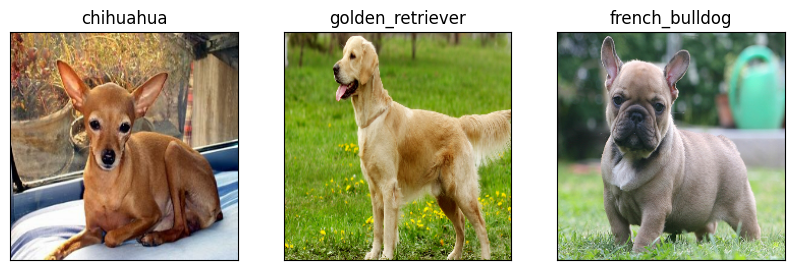

In [ ]:
# Check custom images predictions
plt.figure(figsize=(10, 10))

for i, images in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_predictions_label[i])
  plt.imshow(images)

**Note:** After some experiments to improve our model, our current model is still better. So we decided to stick with current model and do not use the dropout model.